# Air Travel Networks

* Overview
 - Import data on airports and airline routes from https://openflights.org/data.html
 - Files: airlines.dat, airports.dat, countries.dat, routes.dat.

* Data import issues
 - The above website claims that the data is encoded using ISO 8859-1 (Latin-1).
   - But the data is actually UTF-8.
   - Attempting to use Latin-1 encoding will fail.  (Due to some Cyrillic characters?)
 - Postgres bulk import requires that a single-quote at the end of a string be escaped (e.g., the Italian airline Elipiu').
 
* Data schema
 - The data schema (created through SQL, then read in from INFORMATION_SCHEMA) is shown below.
 
* Data integrity
 - Check for NULL values.  (More below)
 
* Data validity
 - The values for the column "Stops" in table "route" aren't realistic.  (More below.)

* Data visualization
 - More below.

<hr style="height:5px;color:black"/>

In [1]:
from collections import Counter
import csv
from math import atan2, cos, sin, radians, sqrt
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import psycopg2
# from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine
import yaml

/Applications/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [77]:
%matplotlib inline

In [2]:
BASE_CONN_STR = os.environ['BASE_CONN_STR']
CREATE_TABLES_YAML_DIR = '../src/'
CREATE_TABLES_YAML_FILE = 'air_travel_tables_sql.yml'
CREATE_TABLES_YAML_PATH = CREATE_TABLES_YAML_DIR + CREATE_TABLES_YAML_FILE
DATA_DIR = '../data/openflights.org/'
DB_NAME = 'air_travel'
DB_USER='postgres'
POSTGRES_HOST='localhost'
POSTGRES_PORT=5432

CONN_STR = BASE_CONN_STR + f" dbname='{DB_NAME}'"

In [3]:
air_traffic_data_files = {
    'airline': 'airlines.dat'
    , 'airport': 'airports.dat'
    , 'country': 'countries.dat'
    , 'route': 'routes.dat'
}
air_traffic_data_column_count = {
    'airline': 8
    , 'airport': 14
    , 'country': 4
    , 'route': 9
}

In [4]:
def create_db():
    cmd_check_db = f"""
        SELECT EXISTS (
            SELECT datname FROM pg_catalog.pg_database
            WHERE lower(datname) = lower('{DB_NAME}')
        )"""
    with psycopg2.connect(BASE_CONN_STR) as conn:
        conn.autocommit = True
        with conn.cursor() as cur:
            cur.execute(cmd_check_db)
            if not cur.fetchone()[0]:
                cur.execute('CREATE DATABASE ' + DB_NAME)

In [5]:
def create_tables():
    
    with open(CREATE_TABLES_YAML_PATH, 'r') as yf:
        create_table_objs = yaml.load(yf)

    with psycopg2.connect(CONN_STR) as conn:
        conn.autocommit = True
        for table_name in create_table_objs:
            cmd_check_table = f"""
                SELECT EXISTS (
                    SELECT * FROM information_schema.tables
                    WHERE lower(table_name) = lower('{table_name}')
                )"""
            with conn.cursor() as cur:
                print(f'INFO: About to check table {table_name}')
                cur.execute(cmd_check_table)
                if not cur.fetchone()[0]:
                    cmd_create_table = create_table_objs[table_name]
                    print(f'INFO: *** About to create table {table_name} ***')
                    cur.execute(cmd_create_table)

In [6]:
def geo_dist(lat1, long1, lat2, long2):
    R = 6373.0  # Radius of the earth, in km
    lat1 = radians(lat1)
    long1 = radians(long1)
    lat2 = radians(lat2)
    long2 = radians(long2)
    dlat = lat2 - lat1
    dlong = abs(long2 - long1)
    a = (sin(dlat / 2))**2 + cos(lat1) * cos(lat2) * (sin(dlong / 2))**2
    angle = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * angle
    return distance

In [7]:
def inspect_db():
    with psycopg2.connect(CONN_STR) as conn:
        with conn.cursor() as cur:
            # Note: Not necessarily the same order used in the SQL DDL
            cur.execute("""
                SELECT Tbl.table_schema
                     , Tbl.table_name
                     , Col.column_name
                     , Col.data_type
                     , Col.character_maximum_length
                FROM INFORMATION_SCHEMA.tables AS Tbl
                    JOIN INFORMATION_SCHEMA.columns AS Col
                      ON Col.table_name = Tbl.table_name
                WHERE Tbl.table_schema = 'public'
                ORDER BY table_schema, table_name
                ;
                """)
            for row in cur:
                print(row)

In [8]:
def is_float(s):
    try:
        _ = float(s)
        return True
    except:
        return False

def is_int(s):
    try:
        _ = int(s)
        return True
    except:
        return False

In [9]:
def upload_data():
    for table, data_file in air_traffic_data_files.items():
        data_path = DATA_DIR + data_file
        num_cols = air_traffic_data_column_count[table]
        values_template_str = ', '.join(['%s'] * num_cols)

        with psycopg2.connect(CONN_STR) as conn:
            with conn.cursor() as cur:
                with open(data_path, 'r') as df:
                    reader = csv.reader(df)
                    # next(reader)  # No header row to skip
                    for row_num, row in enumerate(reader):
                        if len(row) != num_cols:
                            print(f'Warning: Row #{row_num} only has {len(row)} columns')
                            continue
                        cmd_insert = f'INSERT INTO {table} VALUES ({values_template_str})'
                        # print(f'cmd_insert={cmd_insert}')
                        try:
                            cur.execute(cmd_insert, row)
                        except Exception as ex:
                            print(f'ERROR ({ex.__str__().rstrip()}) on row #{row_num}: {row}')

<hr style="height:5px;color:black"/>

# Create and load DB tables 

In [10]:
create_tables()

INFO: About to check table Airline
INFO: *** About to create table Airline ***
INFO: About to check table Airport
INFO: *** About to create table Airport ***
INFO: About to check table Country
INFO: *** About to create table Country ***
INFO: About to check table Route
INFO: *** About to create table Route ***


In [11]:
upload_data()

# Load the four tables of airline data into Jupyter

In [12]:
inspect_db()

('public', 'airline', 'open_flights_airline_id', 'integer', None)
('public', 'airline', 'name', 'character varying', 100)
('public', 'airline', 'alias', 'character varying', 50)
('public', 'airline', 'iata', 'character', 8)
('public', 'airline', 'icao', 'character', 8)
('public', 'airline', 'callsign', 'character varying', 50)
('public', 'airline', 'country', 'character varying', 50)
('public', 'airline', 'active', 'character', 1)
('public', 'airport', 'open_flights_airport_id', 'integer', None)
('public', 'airport', 'name', 'character varying', 100)
('public', 'airport', 'city', 'character varying', 50)
('public', 'airport', 'country', 'character varying', 50)
('public', 'airport', 'iata', 'character', 3)
('public', 'airport', 'icao', 'character', 4)
('public', 'airport', 'latitude', 'character varying', 50)
('public', 'airport', 'longitude', 'character varying', 50)
('public', 'airport', 'altitude', 'character varying', 50)
('public', 'airport', 'timezone', 'character varying', 50)
(

# Data integrity: Check for NULLs

In [13]:
engine = create_engine(f'postgres://{DB_USER}@{POSTGRES_HOST}:{POSTGRES_PORT}/{DB_NAME}')

In [14]:
airline_df = pd.read_sql_table('airline', engine)
airport_df = pd.read_sql_table('airport', engine)
country_df = pd.read_sql_table('country', engine)
route_df = pd.read_sql_table('route', engine)

(airline_df.shape, airport_df.shape, country_df.shape, route_df.shape)

((6162, 8), (7184, 14), (260, 4), (67663, 9))

In [15]:
# Out of 6162 rows:
airline_df.isnull().sum()

open_flights_airline_id    0
name                       0
alias                      0
iata                       0
icao                       0
callsign                   0
country                    0
active                     0
dtype: int64

In [16]:
# Out of 7184 rows:
airport_df.isnull().sum()

open_flights_airport_id    0
name                       0
city                       0
country                    0
iata                       0
icao                       0
latitude                   0
longitude                  0
altitude                   0
timezone                   0
dst                        0
timezone_olson_name        0
airport_type               0
source                     0
dtype: int64

In [17]:
# Out of 260 rows:
country_df.isnull().sum()

name             0
code1            0
code_iso_3166    0
country_group    0
dtype: int64

In [18]:
# Out of 67,663 rows:
route_df.isnull().sum()

airline                    0
open_flights_airline_id    0
source_airport             0
source_airport_id          0
destination_airport        0
destination_airport_id     0
codeshare                  0
stops                      0
equipment                  0
dtype: int64

* Great!  No NULLs.
* But that was achieved only by defining some columns that should contain numeric data (e.g., latitude, longitude) as varchar columns.
* Let's now filter out those rows with incomplete (i.e., non-numeric) data in these columns, and cast them as appropriate.
* **TODO:** Why do some airports not have a recorded timezone?

# Filter and transform airport_df

In [19]:
airport_row_count_raw = airport_df.shape[0]

In [20]:
airport_mask = ((airport_df['latitude'].map(is_float))
                & ((airport_df['longitude'].map(is_float)))
                & (airport_df['altitude'].map(is_float))
                & (airport_df['timezone'].map(is_float))
               )

In [21]:
airport_df = airport_df[airport_mask]

In [22]:
airport_row_count_filtered = airport_df.shape[0]

In [23]:
airport_row_pct_remaining = airport_row_count_filtered / airport_row_count_raw

In [24]:
print(f'Percentage of airport rows remaining: {100*airport_row_pct_remaining:.2f}')

Percentage of airport rows remaining: 95.68


In [25]:
airport_df.dtypes

open_flights_airport_id     int64
name                       object
city                       object
country                    object
iata                       object
icao                       object
latitude                   object
longitude                  object
altitude                   object
timezone                   object
dst                        object
timezone_olson_name        object
airport_type               object
source                     object
dtype: object

In [26]:
airport_df['latitude'] = airport_df['latitude'].astype(float)
airport_df['longitude'] = airport_df['longitude'].astype(float)
airport_df['altitude'] = airport_df['altitude'].astype(float)
airport_df['timezone'] = airport_df['timezone'].astype(float)

In [27]:
airport_df.dtypes

open_flights_airport_id      int64
name                        object
city                        object
country                     object
iata                        object
icao                        object
latitude                   float64
longitude                  float64
altitude                   float64
timezone                   float64
dst                         object
timezone_olson_name         object
airport_type                object
source                      object
dtype: object

# Filter and transform route_df

In [28]:
route_row_count_raw = route_df.shape[0]

In [29]:
route_mask = ((route_df['open_flights_airline_id'].map(is_int))
              & (route_df['source_airport_id'].map(is_int))
              & (route_df['destination_airport_id'].map(is_int))
             )

In [30]:
route_df = route_df[route_mask]

In [31]:
route_row_count_filtered = route_df.shape[0]

In [32]:
route_row_pct_remaining = route_row_count_filtered / route_row_count_raw

In [33]:
print(f'Percentage of airport rows remaining: {100*route_row_pct_remaining:.2f}')

Percentage of airport rows remaining: 98.67


In [34]:
route_df.dtypes

airline                    object
open_flights_airline_id    object
source_airport             object
source_airport_id          object
destination_airport        object
destination_airport_id     object
codeshare                  object
stops                       int64
equipment                  object
dtype: object

In [35]:
route_df['open_flights_airline_id'] = route_df['open_flights_airline_id'].astype(int)
route_df['source_airport_id'] = route_df['source_airport_id'].astype(int)
route_df['destination_airport_id'] = route_df['destination_airport_id'].astype(int)

In [36]:
route_df.dtypes

airline                    object
open_flights_airline_id     int64
source_airport             object
source_airport_id           int64
destination_airport        object
destination_airport_id      int64
codeshare                  object
stops                       int64
equipment                  object
dtype: object

# Data validity: route table: stops
 - The values for the column "Stops" in table "route" aren't realistic.
 - The column "Stops" is described in the above website as
      > Number of stops on this flight ("0" for direct).
 - Let's take a look at the range of values.

In [37]:
Counter(route_df['stops'])

Counter({0: 66754, 1: 11})

* Since there are only a (very, very) small number of stopover flights, we can look at all of them.
* There are too few commercial flights with stopovers for this to be believable.

In [38]:
route_df[route_df['stops'] == 1]

,airline,open_flights_airline_id,source_airport,source_airport_id,destination_airport,destination_airport_id,codeshare,stops,equipment
2066,5T,1623,YRT,132,YEK,50,,1,ATR
7810,AC,330,ABJ,253,BRU,302,,1,333
8272,AC,330,YVR,156,YBL,30,,1,BEH
17767,CU,1936,FCO,1555,HAV,1909,,1,767
25116,FL,1316,HOU,3566,SAT,3621,,1,735
25220,FL,1316,MCO,3878,HOU,3566,,1,73W
25230,FL,1316,MCO,3878,ORF,3611,,1,717
49746,SK,4319,ARN,737,GEV,715,,1,ATP
63567,WN,4547,BOS,3448,MCO,3878,,1,73W
64044,WN,4547,MCO,3878,BOS,3448,,1,73W


# Create a network graph

In [39]:
airport_basics_df = airport_df[['iata', 'city', 'country', 'latitude', 'longitude']]

In [40]:
us_airports_df = airport_basics_df[airport_basics_df['country'] == 'United States'].copy()

In [41]:
us_flights_df = route_df[['source_airport', 'destination_airport']].copy()

In [42]:
us_flights_df = (us_flights_df.merge(us_airports_df, how='inner'
                                 , left_on='source_airport', right_on='iata')
                 .rename(
                    columns={'iata': 'orig_iata'
                             , 'city': 'orig_city'
                             , 'country': 'orig_country'
                             , 'latitude': 'orig_lat'
                             , 'longitude': 'orig_long'
                            }
                 )
                 )

In [43]:
us_flights_df = (us_flights_df.merge(us_airports_df, how='inner'
                                 , left_on='destination_airport', right_on='iata')
                 .rename(
                    columns={'iata': 'dest_iata'
                             , 'city': 'dest_city'
                             , 'country': 'dest_country'
                             , 'latitude': 'dest_lat'
                             , 'longitude': 'dest_long'
                            }
                 )
                 )

In [44]:
us_flights_df

,source_airport,destination_airport,orig_iata,orig_city,orig_country,orig_lat,orig_long,dest_iata,dest_city,dest_country,dest_lat,dest_long
0,ADQ,KLN,ADQ,Kodiak,United States,57.750000,-152.494003,KLN,Larsen Bay,United States,57.535099,-153.977997
1,ADQ,ANC,ADQ,Kodiak,United States,57.750000,-152.494003,ANC,Anchorage,United States,61.174400,-149.996002
2,ADQ,ANC,ADQ,Kodiak,United States,57.750000,-152.494003,ANC,Anchorage,United States,61.174400,-149.996002
3,ORD,ANC,ORD,Chicago,United States,41.978600,-87.904800,ANC,Anchorage,United States,61.174400,-149.996002
4,ORD,ANC,ORD,Chicago,United States,41.978600,-87.904800,ANC,Anchorage,United States,61.174400,-149.996002
5,LAS,ANC,LAS,Las Vegas,United States,36.080101,-115.152000,ANC,Anchorage,United States,61.174400,-149.996002
6,LAX,ANC,LAX,Los Angeles,United States,33.942501,-118.407997,ANC,Anchorage,United States,61.174400,-149.996002
7,LAX,ANC,LAX,Los Angeles,United States,33.942501,-118.407997,ANC,Anchorage,United States,61.174400,-149.996002
8,BET,ANC,BET,Bethel,United States,60.779800,-161.837997,ANC,Anchorage,United States,61.174400,-149.996002
9,BET,ANC,BET,Bethel,United States,60.779800,-161.837997,ANC,Anchorage,United States,61.174400,-149.996002


<hr style="height:5px;color:black"/>

# Require that each airport appears as both source and destination

In [48]:
orig_airports = us_flights_df['orig_iata'].unique()

In [49]:
dest_airports = us_flights_df['dest_iata'].unique()

In [50]:
us_flights_mask = ((us_flights_df['orig_iata'].isin(dest_airports))
                   & (us_flights_df['dest_iata'].isin(orig_airports))
                  )

In [51]:
us_flights2_df = us_flights_df[us_flights_mask].copy()

In [52]:
us_flights2_df.shape[0]

10457

In [53]:
print(f'The filtered US flights dataframe as {100.0 * us_flights2_df.shape[0] / us_flights_df.shape[0]:.2f}% of the original')

The filtered US flights dataframe as 99.85% of the original


In [54]:
us_flights2_df['dist'] = us_flights2_df.apply(
    lambda row: geo_dist(row['orig_lat'], row['orig_long'], row['dest_lat'], row['dest_long'])
    , axis=1)

In [55]:
us_flights2_df[us_flights2_df['dist'] > 8000]

,source_airport,destination_airport,orig_iata,orig_city,orig_country,orig_lat,orig_long,dest_iata,dest_city,dest_country,dest_lat,dest_long,dist
4203,HNL,JFK,HNL,Honolulu,United States,21.318701,-157.921997,JFK,New York,United States,40.639801,-73.778900,8009.206436
8249,JFK,HNL,JFK,New York,United States,40.639801,-73.778900,HNL,Honolulu,United States,21.318701,-157.921997,8009.206436


In [56]:
for k in range(0, 9):
    long_count = us_flights2_df[us_flights2_df['dist'] > k * 1000].shape[0]
    print(f'Routes longer than {k}K km: {long_count}')

Routes longer than 0K km: 10457
Routes longer than 1K km: 5259
Routes longer than 2K km: 1821
Routes longer than 3K km: 858
Routes longer than 4K km: 244
Routes longer than 5K km: 31
Routes longer than 6K km: 19
Routes longer than 7K km: 9
Routes longer than 8K km: 2


# Create network graph from routes

In [57]:
G = nx.from_pandas_dataframe(us_flights2_df, 'orig_iata', 'dest_iata', edge_attr='dist'
                            ,create_using=nx.DiGraph())

In [58]:
G.add_weighted_edges_from((row[1]['orig_iata'], row[1]['dest_iata'], row[1]['dist'])
                          for row in us_flights2_df.iterrows())

In [59]:
us_out_degrees = [G.out_degree(node) for node in G.nodes()]
np.mean(us_out_degrees)

10.307251908396946

In [60]:
us_in_degrees = [G.in_degree(node) for node in G.nodes()]
np.mean(us_in_degrees)

10.307251908396946

In [61]:
pageranks = nx.pagerank(G)

In [63]:
len(G.nodes())

524

In [64]:
top_pageranks = sorted([node for node in pageranks if pageranks[node] > 0.02], key=lambda node: -pageranks[node])
[(node, f'{pageranks[node]:.4f}') for node in top_pageranks]

[('DEN', '0.0286'),
 ('LAS', '0.0244'),
 ('DFW', '0.0224'),
 ('ORD', '0.0223'),
 ('ATL', '0.0220'),
 ('SEA', '0.0208'),
 ('ANC', '0.0207'),
 ('LAX', '0.0200')]

In [66]:
# DEN=Denver; LAS=Los Vegas; DFW=Dallas/Ft Wordth;
# ORD=O'Hare; ATL=Atlanta; SEA=Seattle;
# ANC=Anchorage; LAX=L.A.

<hr style="height:5px;color:black"/>

# Q: Is the Air Travel Network weakly connected?

In [67]:
nx.is_weakly_connected(G)

False

In [68]:
nx.number_weakly_connected_components(G)

3

* **Answer:** No, it's not weakly connected.

In [69]:
wccs = [wcc for wcc in nx.weakly_connected_components(G)]

In [70]:
wcc_sizes = [len(wcc) for wcc in wccs]
wcc_sizes

[517, 3, 4]

In [71]:
wccs[1]

{'AKB', 'DUT', 'KQA'}

* AKB: Atka island, Alaska
* DUT: Unalaska, Alaska
* KQA: Akutan Island, in the Aleutian Islands, Alaska

In [72]:
wccs[2]

{'BFI', 'CLM', 'ESD', 'FRD'}

* BFI: Boeing Field, WA
* CLM: Port Angeles, WA
* ESD: Orcas Island, WA
* FRD: Friday Harbor, WA

<hr style="height:5px;color:black"/>

# Shortest paths

In [73]:
nx.shortest_path(G, 'BRW', 'MIA')

['BRW', 'ANC', 'ORD', 'MIA']

* BRW = Point Barrow, Alaska
* ANC = Anchorage
* ORD = O'Hare airport, Chicago
* MIA = Miami

In [98]:
all_shortest_paths = nx.all_shortest_paths(G, 'BRW', 'MIA')
for shortest_path in all_shortest_paths:
    print(shortest_path)

['BRW', 'ANC', 'ORD', 'MIA']
['BRW', 'ANC', 'DEN', 'MIA']
['BRW', 'ANC', 'LAS', 'MIA']
['BRW', 'ANC', 'LAX', 'MIA']
['BRW', 'ANC', 'MSP', 'MIA']
['BRW', 'ANC', 'PHX', 'MIA']
['BRW', 'ANC', 'SEA', 'MIA']
['BRW', 'FAI', 'SEA', 'MIA']


In [100]:
all_shortest_paths = nx.all_shortest_paths(G, 'BRW', 'MIA', weight='weight')
for shortest_path in all_shortest_paths:
    print(shortest_path)

['BRW', 'ANC', 'MSP', 'MIA']


In [101]:
# from networkx.utils import all_pairs_dijkstra_path_length
shortest_paths = nx.dijkstra_path(G, source='BRW', target='MIA', weight='weight')
print(shortest_paths)

['BRW', 'ANC', 'MSP', 'MIA']


In [107]:
print(f"{nx.shortest_path_length(G, 'BRW', 'MIA', weight='weight'):.2f}")

7625.25


<hr style="height:5px;color:black"/>

# Plot the US domestic routes

In [74]:
nodes_to_remove = ['AKB', 'DUT', 'KQA'
                   , 'BFI', 'CLM', 'ESD', 'FRD'
                   , 'KLN']
for node in nodes_to_remove:
    G.remove_node(node)

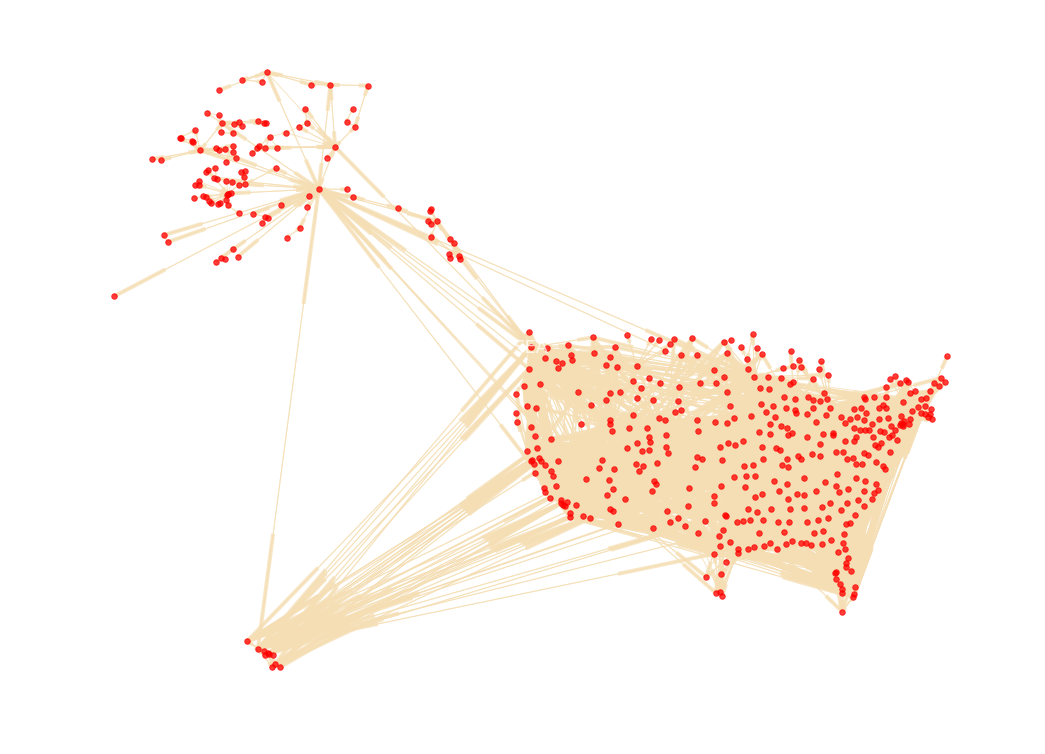

In [75]:
plt.figure(figsize=(14, 10))
airport_to_pos = list(zip(us_flights2_df['orig_iata']
                        , zip(us_flights2_df['orig_long'], us_flights2_df['orig_lat'])
                           ))
nx.draw(G, pos=dict(airport_to_pos), alpha=0.75, node_size=30, node_color='r'
        , edge_color='wheat'
        , labels={'SEA': 'SEA'}, font_color='w', font_size=18, with_labels=True)
plt.show()
# plt.axis('off')
# plt.tight_layout();

<hr style="height:5px;color:black"/>

### Data visualization: Domestic vs. international flights

domestic_international_sql = """
    SELECT airline_ AS airline
          , domestic_flights
          , international_flights
          , ROUND(100.0 * domestic_flights / (domestic_flights + international_flights), 2) AS domestic_percentage
          , flights
    FROM (
        SELECT airline.name as airline_
             , SUM(CASE WHEN src_airport.country = dst_airport.country THEN 1 ELSE 0 END) AS domestic_flights
             , SUM(CASE WHEN src_airport.country <> dst_airport.country THEN 1 ELSE 0 END) AS international_flights
             , COUNT(*) AS flights
        FROM route
            JOIN airline
                ON airline.open_flights_airline_id = route.open_flights_airline_id
            JOIN airport AS src_airport
                ON src_airport.open_flights_airport_id = route.source_airport_id
            JOIN airport AS dst_airport
                ON dst_airport.open_flights_airport_id = route.destination_airport_id
        GROUP BY airline_
    ) AS tmp
    ORDER BY flights DESC
    """
domestic_international_df = pd.read_sql_query(domestic_international_sql, engine)
domestic_international_df.describe()

domestic_international_df.set_index(['airline'])
domestic_international_df.head()

%matplotlib inline

ax = domestic_international_df[:10]['domestic_percentage'].plot(
    kind='bar'
    , title='Percentage of Domestic Flights by Airline')
ax.set(xlabel='Airline', ylabel='Percentage of domestic flights')
ax.set_xticklabels(domestic_international_df.airline)
plt.tight_layout()

### Data visualization: Flights between different countries

international_traffic_sql = """
    WITH top20countries
    AS (
        SELECT country_ AS country
              , SUM(flights) AS flights
        FROM (
            SELECT src_airport.country AS country_
                  , COUNT(*) AS flights
            FROM route
            JOIN airport AS src_airport
                ON src_airport.open_flights_airport_id = route.source_airport_id
            GROUP BY src_airport.country
          UNION
            SELECT dst_airport.country AS country_
                  , COUNT(*) AS flights
            FROM route
            JOIN airport AS dst_airport
                ON dst_airport.open_flights_airport_id = route.source_airport_id
            GROUP BY dst_airport.country
        ) AS SrcDst
        GROUP BY country_
        ORDER BY flights DESC
        LIMIT 20
    )
    SELECT src_airport.country AS src_country
          , dst_airport.country AS dst_country
          , COUNT(*) AS flights
    FROM route
        JOIN airline
            ON airline.open_flights_airline_id = route.open_flights_airline_id
        JOIN airport AS src_airport
            ON src_airport.open_flights_airport_id = route.source_airport_id
        JOIN airport AS dst_airport
            ON dst_airport.open_flights_airport_id = route.destination_airport_id
        JOIN top20countries AS src_country_filter
            ON src_country_filter.country = src_airport.country
        JOIN top20countries AS dst_country_filter
            ON dst_country_filter.country = dst_airport.country
    GROUP BY src_airport.country, dst_airport.country
    ORDER BY flights DESC
"""

international_traffic_df = pd.read_sql_query(international_traffic_sql, engine)
international_traffic_df.head()

international_traffic_df.tail()

international_traffic_df.shape[0]

 - The number of rows is less than 400, so there would be "holes" in a 20*20 array.
 - That's OK---we'll fill them with zeroes.

country_xchange = international_traffic_df.groupby(['src_country', 'dst_country']).sum().unstack('dst_country').fillna(0)
country_xchange

import seaborn as sns

sns.heatmap(country_xchange);

 - It's hard to see any detail because the larger values along the diagonal (representing domestic flights, especially for China and the United States) wash out the rest of the heatmap.  Let's try setting the diagonal entries to zero.

import numpy as np
np.fill_diagonal(country_xchange.values, 0)
sns.heatmap(country_xchange);

We can see that there are lots of flights:
 - between the UK and Spain
 - between the US and Mexico
 - between the US and Canada
 - between Germany and Spain

engine.dispose()

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon

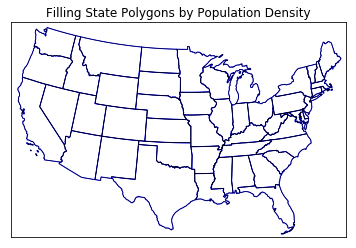

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
# Lambert Conformal map of lower 48 states.
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
# Draw state boundaries.
# Data from U.S Census Bureau @ http://www.census.gov/geo/www/cob/st2000.html
shp_info = m.readshapefile('../data/census.gov/cb_2016_us_state_20m','states',drawbounds=True)
colors={}
statenames=[]
# cmap = plt.cm.hot # use 'hot' colormap
vmin = 0; vmax = 450 # set range.
for shapedict in m.states_info:
    statename = shapedict['NAME']
    statenames.append(statename)
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(m.states):
    poly = Polygon(seg, facecolor='w', edgecolor='b')
    ax.add_patch(poly)
plt.title('Filling State Polygons by Population Density')
plt.show()